In [1]:
import itertools
import json
import pickle

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
with open('../data/raw/raw2.json') as data_file:    
    data = json.load(data_file)

In [4]:
responses = [r['doc'] for r in data['rows']]

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.loc[:, 'startedAt'] = pd.to_datetime(df.startedAt)
df.loc[:, 'completedAt'] = pd.to_datetime(df.completedAt)
df.loc[:, 'duration'] = (df.completedAt - df.startedAt)
df.loc[:, 'durationSeconds'] = df.duration.apply(lambda d: d.total_seconds())

In [7]:
## Event counts for each question
events = list(df.events)
combined_events = list(itertools.chain(*events))
eventsdf = pd.DataFrame(combined_events)

In [8]:
# Moved slider event count
survey_events = eventsdf[eventsdf.type == 'Moved Slider']
event_counts = (survey_events
    .groupby(['sessionId', 'question'])
    ._id.agg('count')
    .unstack()
    .reset_index()
    .fillna(0))

In [9]:
event_counts.columns = [
    'sessionId', 'ev0', 'ev1', 
    'ev2', 'ev3', 'ev4', 'ev5'
]

In [10]:
with_event_counts = pd.merge(
    df, 
    event_counts, 
    left_on='_id', 
    right_on='sessionId', 
    how='left'
)

In [11]:
# Instruction counts for each question
instruction = eventsdf[eventsdf.type != 'Moved Slider']
instruction_count = (instruction
    .groupby(['sessionId', 'question'])
    ._id.agg('count')
    .unstack()
    .reset_index()
    .fillna(0))

In [12]:
instruction_count.columns = [
    'sessionId', 'i0', 'i1', 
    'i2', 'i3', 'i4', 'i5'
]

In [13]:
with_instruction_count = pd.merge(
    with_event_counts, 
    instruction_count,
    left_on='_id', 
    right_on='sessionId', 
    how='left'
)

In [14]:
## Answers for each question
answers = list(df.answers)
combined_answers = list(itertools.chain(*answers))
adf = pd.DataFrame(combined_answers)
adf['question'] = adf.question.astype(int)

In [15]:
mean_times = adf.groupby('sessionId').resonseTime.agg('mean')

In [16]:
rtdf = adf[['sessionId', 'question', 'resonseTime']]

In [17]:
svo = rtdf[rtdf.question < 6]

In [18]:
svo.groupby('question').resonseTime.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
question,,,,,,,,
0,849.0,18413.128386,22023.935269,105.0,8084.00,13401.0,21364.00,314691.0
1,842.0,11909.523753,9461.242972,389.0,5216.50,9405.0,15249.25,62125.0
2,844.0,7999.302133,9254.703139,149.0,3705.50,6041.5,9975.00,205726.0
3,843.0,9398.085409,11791.422250,16.0,3720.50,7232.0,12242.00,243804.0
4,843.0,4474.065243,4206.101205,16.0,2021.00,3237.0,5570.00,62669.0
5,844.0,6267.755924,6669.454095,5.0,2861.25,4672.0,7637.75,89398.0


In [20]:
svo.loc[:, 'responseSec'] = svo.resonseTime / 1000

/Users/pdarche/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


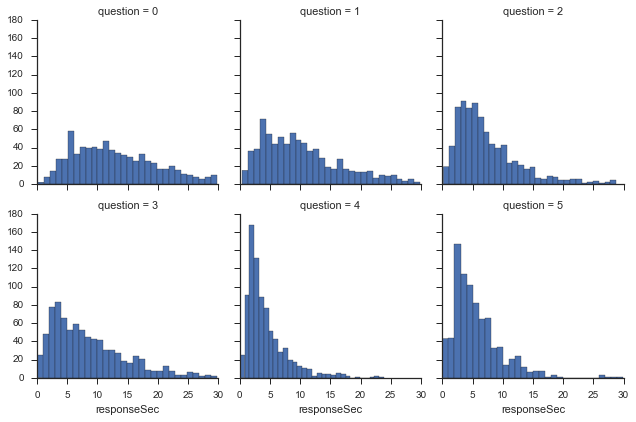

In [358]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(svo[svo.responseSec < 30], col="question", col_wrap=3)
g = g.map(plt.hist, "responseSec", bins=30)

In [21]:
# rtdf.pivot_table(index='sessionId', values=['question', 'resonseTime'])
# rtdf.pivot_table(index='sessionId', columns=['question', 'resonseTime'])
rows = []
for name, group in svo.groupby('sessionId'):
    res = group.resonseTime.transpose()
    row = [name] + list(res)
    if len(row) == 7:
        rows.append(row)

In [22]:
timedf = pd.DataFrame(data=rows, columns=['sessionId', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5'])

### Look for responses that were too quick
Thought process: I'm looking for people who were just clcking the buttons and not moving on.  Once way of determining that is to see how long they took to answer each question.  I could see if the were going that across the board (just clicking for all answers) or if they were taking very little time on any one answer.

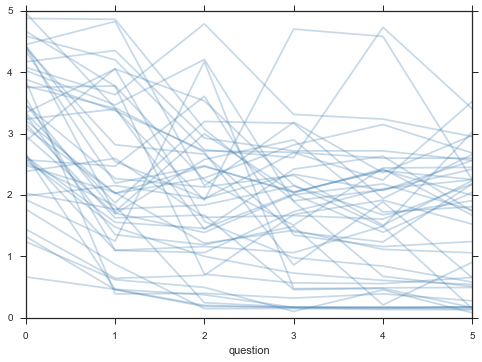

In [361]:
fig, ax = plt.subplots(1, 1)
# svo.groupby('sessionId').plot.line(x='question', y='responseSec', ax=ax, alpha=0.7)
bad_sessions = []
for name, group in svo.groupby('sessionId'):
    if (group.responseSec < 5).all():
        group.plot(x='question', y='responseSec', ax=ax, alpha=0.3, legend=False, color='steelblue')
        bad_sessions.append(name)

In [362]:
bdf = df[df._id.isin(bad_sessions)]
bdf.shape

(44, 16)

In [73]:
with open('./bad_data.pickle', 'wb') as f:
    pickle.dump(bdf, f)

/Users/pdarche/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


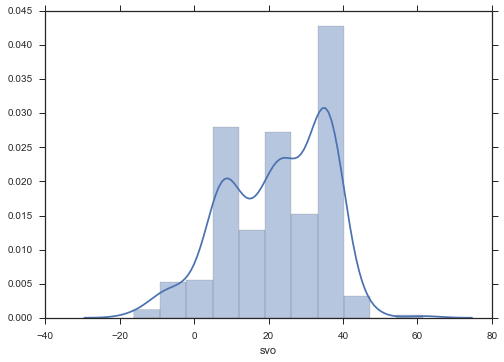

In [81]:
sns.distplot(bdf[bdf.svo.notnull()].svo)

In [260]:
# svo.groupby('sessionId').get_group('00df99c23deb47a45ff5f4a80df687b0').responseSec.transpose()

### Review the events
Thinking: I'm looking to see if there are any patterns in the events that would indicate whether or not the person was taking the question seriously.  It could be the case that they didn't move the slider at all and just clicked through, or it could be that they just moved it to one place very quickly

In [23]:
eventsdf.loc[:, 'occuredAt'] = eventsdf.occuredAt.apply(pd.to_datetime)

In [24]:
eventsdf.loc[:, 'selfDiff'] = (eventsdf.self - eventsdf.selfStart)
eventsdf.loc[:, 'diffSum'] = eventsdf.groupby('question').selfDiff.cumsum()
eventsdf.loc[:, 'otherDiff'] = (eventsdf.other - eventsdf.otherStart)
eventsdf.loc[:, 'otherDiffSum'] = eventsdf.groupby('question').otherDiff.cumsum()

In [25]:
# start normalizing times
# eventsdf.groupby(['sessionId', 'question']).first().occuredAt
# eventsdf.loc[:, 'timeOffset'] = (eventsdf.)

In [121]:
df = pd.read_csv('../data/clean/surveys.csv')

In [122]:
with open('./bad_data.pickle', 'rb') as f:
    bdf = pickle.load(f)

In [123]:
with open('./transative_df.pickle', 'rb') as f:
    tdf = pickle.load(f)

In [125]:
df = df.merge(tdf, how='left', left_on='_id', right_on='session')

In [126]:
merged = eventsdf.merge(
    df[["_id", "svo", "type", "transitive"]], 
    how='left', left_on='sessionId', right_on='_id')

In [145]:
grouped = merged[(merged.svo > 18) & (merged.svo < 22)].groupby('sessionId')

In [146]:
sample_groups = list(grouped.groups.keys())
# sample_groups = list(bdf._id)

In [148]:
# test = grouped.get_group(sample_groups[23]).sort_values('occuredAt').groupby('question')
# test.first().ix[0]['type_y']

In [142]:
# test.head()
sns.set(style="ticks", color_codes=True)

In [153]:
test.first().iloc[0]

_id_x           c5ea3e0e2eb0380c1c876a5a81763803
category                                  Survey
occuredAt             2017-03-25 19:44:35.615000
other                                         58
otherStart                                  57.5
self                                     67.2941
selfStart                                   67.5
sessionId       aa431f7ef61b92bbf9b54f1176dcf1f5
type_x                  Opened help instructions
value                                        NaN
selfDiff                               -0.205882
diffSum                                  1475.35
otherDiff                                    0.5
otherDiffSum                            -3582.99
_id_y           aa431f7ef61b92bbf9b54f1176dcf1f5
svo                                      18.7247
type_y                           individualistic
transitive                                  True
Name: 3, dtype: object

/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736421.670118, right=736421.670118
  'left=%s, right=%s') % (left, right))
/Users/pdarche/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736421.623655, right=736421.623655
  'left=%s, right=%s') % (left, right))


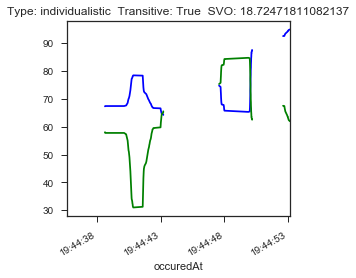

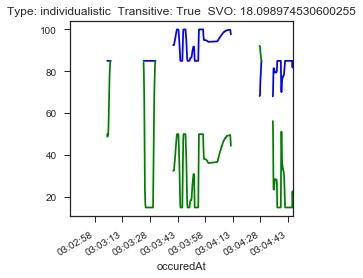

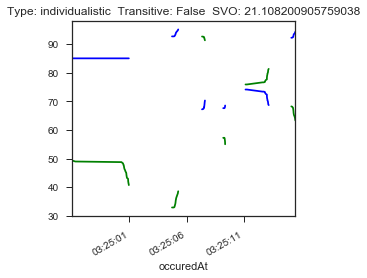

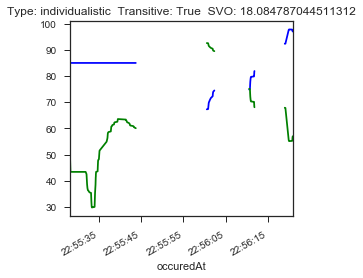

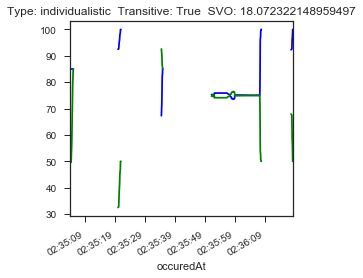

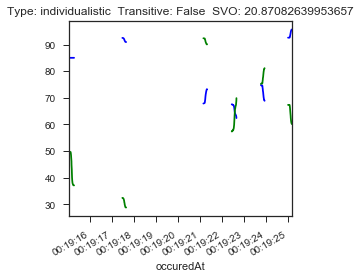

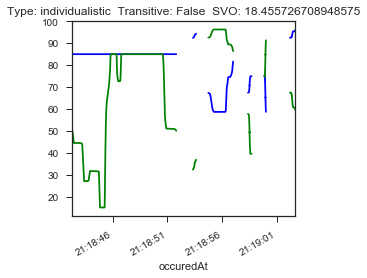

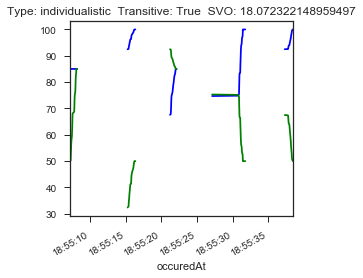

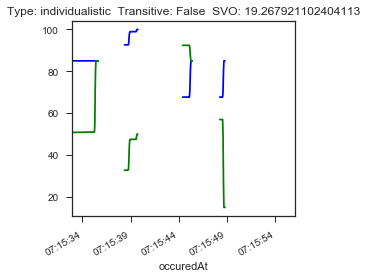

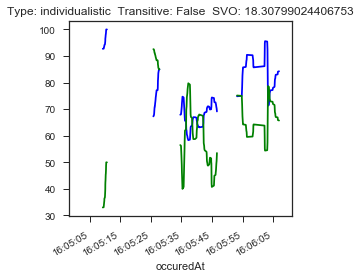

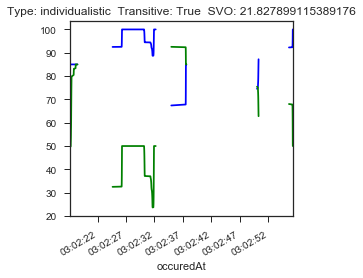

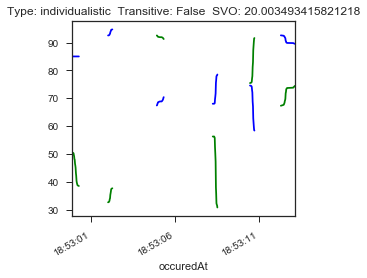

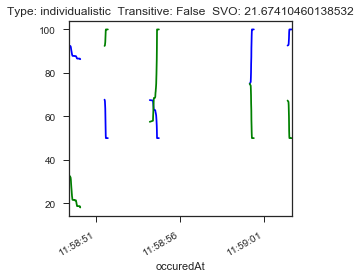

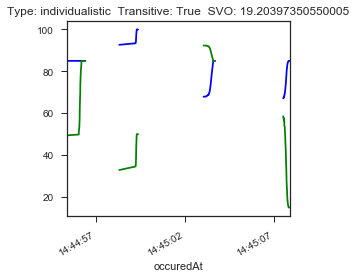

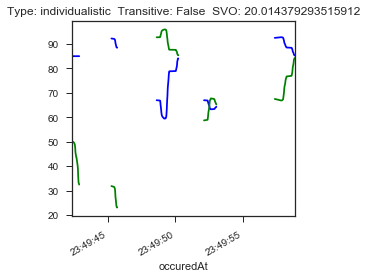

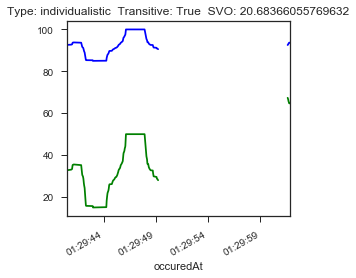

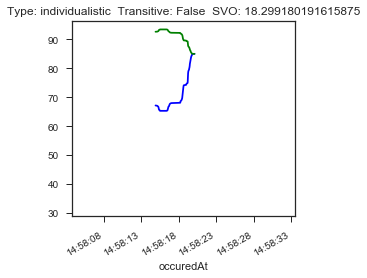

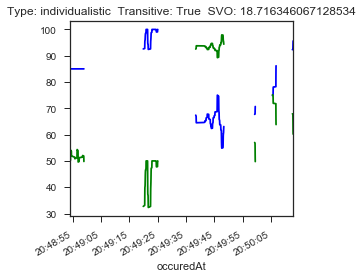

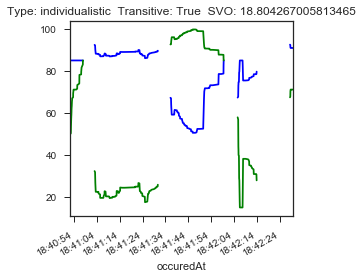

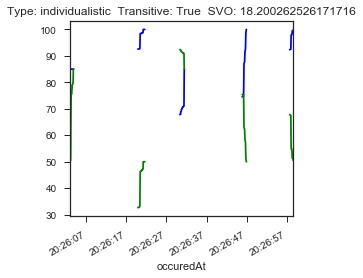

In [155]:
# fig, axes = plt.subplots(ncols=3, sharey=True)
for ix in range(0, 20):
    fig, ax = plt.subplots(1, 1)
    test = grouped.get_group(sample_groups[ix]).sort_values('occuredAt').groupby('question')
    type_ = test.first().iloc[0]['type_y']
    trans = test.first().iloc[0]['transitive']
    svo = test.first().iloc[0]['svo']
    plt.title("Type: {}  Transitive: {}  SVO: {}".format(type_, trans, svo))
    test.plot(x='occuredAt', y='self', ax=ax, legend=False, color='blue', figsize=(4,3))
    test.plot(x='occuredAt', y='other', ax=ax, legend=False, color='green', figsize=(4,4));

In [2]:
fig, ax = plt.subplots(1, 1)
test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='self', ax=ax, legend=False, color='steelblue')
test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='other', ax=ax, legend=False, color='green');

NameError: name 'plt' is not defined

In [373]:
# for _id in sample_groups:
#     test = grouped.get_group(sample_groups[4])
#     fig, ax = plt.subplots(1, 1)
#     test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='diffSum', ax=ax, legend=False, color='steelblue')
#     test.sort_values('occuredAt').groupby('question').plot(x='occuredAt', y='otherDiffSum', ax=ax, legend=False, color='green')

### Transitivity Check

In [309]:
EQUALITY_POINTS = [81, 95, 81, 93, 85, 92, 75, 93, 92]
JOINT_GAIN_POINTS = [70, None, 100, 90, None, 100, None, 100, 90]
OTHER_GAIN = [70, 90, 50, 90, 70, 50, 50, 100, 90]
OWN_GAIN = [100, 100, 100, 100, 100, 100, 100, 100, 100]
MAX_DISTANCES = [20, 10, 50, 10, 30, 50, 50, 30, 10]
questions = [
    {'min1': 85, 'max1': 85.01, 'min2': 85, 'max2': 15},
    {'min1': 85, 'max1': 100, 'min2': 15, 'max2': 50},
    {'min1': 50, 'max1': 85, 'min2': 100, 'max2': 85},
    {'min1': 50, 'max1': 85, 'min2': 100, 'max2': 15},
    {'min1': 100,' max': 50, 'min2': 50, 'max2': 100},
    {'min1': 100,' max': 85, 'min2': 50, 'max2': 85},
    {'min1': 100,' max': 70, 'min2': 50, 'max2': 100},
    {'min1': 90, 'max1': 100, 'min2': 100, 'max2': 90},
    {'min1': 100,' max': 50, 'min2': 70, 'max2': 100},
    {'min1': 100,' max': 90, 'min2': 70, 'max2': 100},
    {'min1': 70, 'max1': 100, 'min2': 100, 'max2': 70},
    {'min1': 50, 'max1': 100, 'min2': 100, 'max2': 90},
    {'min1': 50, 'max1': 100, 'min2': 100, 'max2': 50},
    {'min1': 100,' max': 70, 'min2': 90,  'max2': 100},
    {'min1': 90, 'max1': 100, 'min2': 100, 'max2': 50},
]

qlist = [
   [85, 85, 85, 15],
   [85, 15, 100,  50],
   [50, 100, 85, 85],
   [50, 100, 85, 15],
   [100, 50, 50,  100],
   [100, 50, 85, 85]
]

test_d = [
    {'self': 85, 'other': 85},
    {'self': 100, 'other': 50},
    {'self': 85, 'other': 85},
    {'self': 50, 'other': 100}, 
    {'self': 75, 'other': 75},
    {'self': 85, 'other': 85}    
]

categories = [
    [2-1, 4-1], [4-1, 3-1],
    [1-1, 2-1], [1-1, 4-1],
    [3-1, 1-1], [3-1, 2-1]
]; # 1=alt, 2=prosoc, 3=ind, 4=comp

# input_matrix =[85    85; 100    50; 85    85; 50   100; 75    75; 85    85];

In [261]:
answer_groups = adf[adf.question < 6].groupby('sessionId')

In [262]:
test_group = answer_groups.get_group('0729682e64a18262740301c4c0ceecdd')

In [263]:
from scipy.spatial.distance import euclidean

In [264]:
def compute_dist(d, ix):
    self_dist = euclidean([d['self'], d['other']], qlist[ix][:2])
    other_dist = euclidean([d['self'], d['other']], qlist[ix][2:])
    return [self_dist, other_dist]

In [338]:
def transitivity_check(answers):
    distance_matrix = []
    for ix in range (0,6):
        ans = answers[ix]
        dist = compute_dist(ans, ix)
        distance_matrix.append(dist)

    ranking = np.zeros(4)
    compare1 = np.full(6, -1)
    compare2 = np.full(6, -1)

    for ix in range (0,6):
        if distance_matrix[ix][0] < distance_matrix[ix][1]:
            compare1[ix] = categories[ix][0]
            compare2[ix] = categories[ix][1]
            ranking[categories[ix][0]] = ranking[categories[ix][0]] + 1
            ranking[categories[ix][1]] = ranking[categories[ix][1]] + 0 
        elif distance_matrix[ix][0] > distance_matrix[ix][1]:
            compare2[ix] = categories[ix][0]
            compare1[ix] = categories[ix][1]
            ranking[categories[ix][0]] = ranking[categories[ix][0]] + 0
            ranking[categories[ix][1]] = ranking[categories[ix][1]] + 1        
        elif distance_matrix[ix][0] == distance_matrix[ix][1]:
            ranking[categories[ix][0]] = ranking[categories[ix][0]] + .5
            ranking[categories[ix][1]] = ranking[categories[ix][1]] + .5

    c1 = compare1[compare1!=-1]
    c2 = compare2[compare2!=-1]
    zipped = list(zip(c1, c2))

    A = np.zeros((4,4))
    for point in zipped:
        A[point] += 1

    G = nx.DiGraph(A)
    transitive = nx.is_directed_acyclic_graph(G)
    return transitive

    # if it's transitive, return the preference ordering
    # if not, return null for the preferences
    #     return A

In [339]:
M = transitivity_check(test_d)

/Users/pdarche/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(6, -1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/pdarche/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [346]:
tran_series = []
for name, group in answer_groups:
    if group.question.count() == 6:
        answers = group.to_dict(orient='records')
        trans = transitivity_check(answers)
        tran_series.append([name, trans])

/Users/pdarche/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(6, -1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/pdarche/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [374]:
tdf = pd.DataFrame(tran_series, columns=['session', 'transitive'])

In [379]:
with open('./transative_df.pickle', 'wb') as f:
    pickle.dump(tdf, f)

In [380]:
mdf = pd.merge(bdf, tdf, how='left', left_on='_id', right_on='session')

In [382]:
mdf.transitive.value_counts()

True     32
False    12
Name: transitive, dtype: int64

### Single Data test

In [289]:
distance_matrix = []
for ix in range (0,6):
    d = test_d[ix]
    dist = compute_dist(d, ix)
    distance_matrix.append(dist)

In [290]:
ranking = np.zeros(4)
compare1 = np.full(6, -1)
compare2 = np.full(6, -1)

for ix in range (0,6):
    if distance_matrix[ix][0] < distance_matrix[ix][1]:
        compare1[ix] = categories[ix][0]
        compare2[ix] = categories[ix][1]
        ranking[categories[ix][0]] = ranking[categories[ix][0]] + 1
        ranking[categories[ix][1]] = ranking[categories[ix][1]] + 0 
    elif distance_matrix[ix][0] > distance_matrix[ix][1]:
        compare2[ix] = categories[ix][0]
        compare1[ix] = categories[ix][1]
        ranking[categories[ix][0]] = ranking[categories[ix][0]] + 0
        ranking[categories[ix][1]] = ranking[categories[ix][1]] + 1        
    elif distance_matrix[ix][0] == distance_matrix[ix][1]:
        ranking[categories[ix][0]] = ranking[categories[ix][0]] + .5
        ranking[categories[ix][1]] = ranking[categories[ix][1]] + .5

/Users/pdarche/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(6, -1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [291]:
c1 = compare1[compare1!=-1]

In [292]:
c2 = compare2[compare2!=-1]

In [293]:
zipped = list(zip(c1, c2))
zipped

[(1.0, 3.0), (2.0, 3.0), (1.0, 0.0), (0.0, 3.0), (1.0, 2.0)]

In [294]:
# sp.sparse.bsr_matrix(zipped, shape=(4,4))

In [295]:
mat = np.zeros((4,4))
for point in zipped:
    mat[point] += 1
mat

/Users/pdarche/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


array([[ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.]])

In [229]:
G = nx.DiGraph(mat)

In [230]:
nx.is_directed_acyclic_graph(G)

True